# Training public data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.utils import np_utils
from tensorflow.keras import optimizers

In [2]:
data = pd.read_csv("SFU-IMU Dataset/combined_data")

data

,user,activity,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z
0,1,No Fall,1304800745101560,-9.331350,-0.676874,0.698558,0.169633,0.961848,-0.203295,31.686542,-61.460714,2.596294
1,1,No Fall,1304800745109370,-9.284102,-0.650755,0.670260,0.178388,0.977692,-0.215142,34.125211,-61.381956,2.551151
2,1,No Fall,1304800745117180,-9.288780,-0.650825,0.665558,0.180301,0.998246,-0.215018,33.980021,-67.447573,-0.339319
3,1,No Fall,1304800745125000,-9.349939,-0.670224,0.663273,0.170527,1.016790,-0.208953,36.563880,-61.303199,2.506008
4,1,No Fall,1304800745132810,-9.378239,-0.684514,0.656242,0.186594,1.029167,-0.190903,36.373585,-67.178578,2.045960
...,...,...,...,...,...,...,...,...,...,...,...,...
475759,4,No Fall,1305081798343750,-9.612718,-1.422527,1.491337,-0.069815,1.066145,0.167339,30.391259,-3.075314,-3.201821
475760,4,No Fall,1305081798351560,-9.687350,-1.395880,1.552637,-0.056382,1.063349,0.155407,22.985043,-2.931111,1.794452
475761,4,No Fall,1305081798359370,-9.750197,-1.362117,1.639818,-0.046599,1.054244,0.095638,24.998018,-14.412874,3.259636
475762,4,No Fall,1305081798367180,-9.745572,-1.364354,1.660997,-0.036400,1.059320,0.143483,25.563964,-0.104902,-0.451089


In [3]:
# All data collected in 50Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
LABELS = list(data.groupby(["activity"]).groups.keys())

no_of_features = 9

# The number of steps within one time segment (window size)
TIME_PERIODS = 1921
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 300

LABELS

['Fall', 'No Fall']

In [4]:
# split the data into training and test set
Training_data = data[data["user"].isin([1, 2, 3])]
Test_data = data[data["user"] == 4]
Test_data

,user,activity,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z
149196,4,No Fall,1305083426210930,-9.871,-0.416,1.188,0.213,1.283,-0.022,32.817,-73.069,-6.084
149197,4,No Fall,1305083426218750,-9.930,-0.440,1.195,0.201,1.263,-0.028,30.379,-73.147,-6.039
149198,4,No Fall,1305083426226560,-10.001,-0.435,1.219,0.187,1.253,0.014,30.424,-73.338,-8.469
149199,4,No Fall,1305083426234370,-9.987,-0.437,1.231,0.182,1.254,-0.004,28.175,-67.541,-7.964
149200,4,No Fall,1305083426242180,-9.949,-0.455,1.191,0.167,1.229,0.002,30.804,-61.587,-7.549
...,...,...,...,...,...,...,...,...,...,...,...,...
475759,4,No Fall,1305081798343750,-9.613,-1.423,1.491,-0.070,1.066,0.167,30.391,-3.075,-3.202
475760,4,No Fall,1305081798351560,-9.687,-1.396,1.553,-0.056,1.063,0.155,22.985,-2.931,1.794
475761,4,No Fall,1305081798359370,-9.750,-1.362,1.640,-0.047,1.054,0.096,24.998,-14.413,3.260
475762,4,No Fall,1305081798367180,-9.746,-1.364,1.661,-0.036,1.059,0.143,25.564,-0.105,-0.451


In [5]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['activity'].values.ravel())
print(list(le.classes_))
Training_data

['Fall', 'No Fall']


<ipython-input-5-50e6bb0b2948>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Training_data['encoded_label'] = le.fit_transform(Training_data['activity'].values.ravel())


,user,activity,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,encoded_label
0,1,No Fall,1304800745101560,-9.331,-0.677,0.699,0.170,0.962,-0.203,31.687,-61.461,2.596,1
1,1,No Fall,1304800745109370,-9.284,-0.651,0.670,0.178,0.978,-0.215,34.125,-61.382,2.551,1
2,1,No Fall,1304800745117180,-9.289,-0.651,0.666,0.180,0.998,-0.215,33.980,-67.448,-0.339,1
3,1,No Fall,1304800745125000,-9.350,-0.670,0.663,0.171,1.017,-0.209,36.564,-61.303,2.506,1
4,1,No Fall,1304800745132810,-9.378,-0.685,0.656,0.187,1.029,-0.191,36.374,-67.179,2.046,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446942,3,No Fall,1304968005695310,-9.343,0.705,2.930,0.143,1.111,0.043,23.865,-31.218,-5.288,1
446943,3,No Fall,1304968005703120,-9.347,0.711,2.934,0.143,1.112,0.025,26.068,-36.824,-3.363,1
446944,3,No Fall,1304968005710930,-9.368,0.737,2.946,0.142,1.107,-0.011,31.231,-27.853,-2.763,1
446945,3,No Fall,1304968005718750,-9.396,0.745,2.953,0.139,1.108,0.007,30.905,-33.158,4.068,1


In [6]:
def normalize_features(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [7]:
for i in range(3,12):
    print(data.columns[i])
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i])
    
Training_data

accel_x
mean:  -7.354704222903448
standard deviation:  4.860833184966956
accel_y
mean:  0.9013582333866001
standard deviation:  2.572025777267715
accel_z
mean:  1.8029134231530743
standard deviation:  4.306372374026702
gyro_x
mean:  0.12358182850254006
standard deviation:  0.43326954030839354
gyro_y
mean:  1.095260964633983
standard deviation:  0.6146833983789973
gyro_z
mean:  0.012618653500433953
standard deviation:  0.35573661356407615
mag_x
mean:  29.8335525183183
standard deviation:  17.339008791803405
mag_y
mean:  -31.79541952334974
standard deviation:  19.28137019681609
mag_z
mean:  -13.624275052765583
standard deviation:  19.889124465336526


C:\Users\wamik\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,user,activity,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,encoded_label
0,1,No Fall,1304800745101560,-0.407,-0.614,-0.256,0.106,-0.217,-0.607,0.107,-1.539,0.816,1
1,1,No Fall,1304800745109370,-0.397,-0.603,-0.263,0.126,-0.191,-0.640,0.248,-1.534,0.813,1
2,1,No Fall,1304800745117180,-0.398,-0.603,-0.264,0.131,-0.158,-0.640,0.239,-1.849,0.668,1
3,1,No Fall,1304800745125000,-0.410,-0.611,-0.265,0.108,-0.128,-0.623,0.388,-1.530,0.811,1
4,1,No Fall,1304800745132810,-0.416,-0.617,-0.266,0.145,-0.108,-0.572,0.377,-1.835,0.788,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446942,3,No Fall,1304968005695310,-0.409,-0.077,0.262,0.044,0.025,0.084,-0.344,0.030,0.419,1
446943,3,No Fall,1304968005703120,-0.410,-0.074,0.263,0.045,0.027,0.034,-0.217,-0.261,0.516,1
446944,3,No Fall,1304968005710930,-0.414,-0.064,0.265,0.043,0.020,-0.067,0.081,0.204,0.546,1
446945,3,No Fall,1304968005718750,-0.420,-0.061,0.267,0.035,0.020,-0.016,0.062,-0.071,0.890,1


In [8]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
        mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
        mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
        mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, mag_xs, mag_ys, mag_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, mag_xs, mag_ys, mag_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [9]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (1183, 1921, 9)
y shape:  (1183,)


In [10]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(1183, 17289)

In [11]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (1183, 2)


In [12]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(200, 3, activation='relu'))
model_m.add(MaxPooling1D(4))
model_m.add(Conv1D(256, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(200, 2, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1921, 9)           0         
                                                                 
 conv1d (Conv1D)             (None, 1919, 200)         5600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 479, 200)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 477, 256)          153856    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 159, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 158, 200)          1

In [13]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

# opt = optimizers.Adam(learning_rate=0.0001)

model_m.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      shuffle = True,
                      verbose=1)

Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 0.7061 - accuracy: 0.4767 - val_loss: 0.8114 - val_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 2s 734ms/step - loss: 0.6645 - accuracy: 0.4514 - val_loss: 0.7457 - val_accuracy: 0.0633
Epoch 3/50
3/3 [==============================] - 2s 735ms/step - loss: 0.6439 - accuracy: 0.6152 - val_loss: 0.8360 - val_accuracy: 0.0295
Epoch 4/50
3/3 [==============================] - 2s 735ms/step - loss: 0.6105 - accuracy: 0.5973 - val_loss: 0.7965 - val_accuracy: 0.1814
Epoch 5/50
3/3 [==============================] - 2s 733ms/step - loss: 0.5609 - accuracy: 0.8214 - val_loss: 0.7518 - val_accuracy: 0.2996
Epoch 6/50
3/3 [==============================] - 2s 738ms/step - loss: 0.4875 - accuracy: 0.8932 - val_loss: 0.6450 - val_accuracy: 0.5992
Epoch 7/50
3/3 [==============================] - 2s 733ms/step - loss: 0.4031 - accuracy: 0.9345 - val_loss: 0.6903 - val_accuracy: 0.5359
Epoch 8/50
3/3 [===

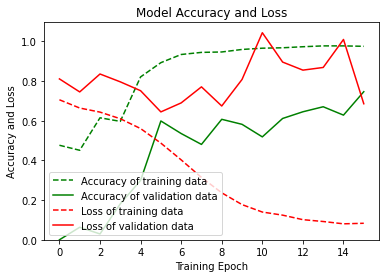

In [14]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [15]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(200, input_shape=(TIME_PERIODS,no_of_features)))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(100, activation='relu'))
# model_lstm.add(Dense(len(LABELS), activation='softmax'))
# print(model_lstm.summary())

In [16]:
# x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
# x_train.shape

In [17]:
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

# # opt = optimizers.SGD(learning_rate=0.01, momentum = 1)

# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# BATCH_SIZE = 400
# EPOCHS = 50

# history = model_lstm.fit(x_train,
#                       y_train,
#                       batch_size=BATCH_SIZE,
#                       epochs=EPOCHS,
#                       callbacks=callbacks_list,
#                       validation_split=0.2,
#                       shuffle = True,
#                       verbose=1)

In [18]:
# Set input_shape / reshape for Keras
# Encode labels
le = preprocessing.LabelEncoder()
Test_data['encoded_label'] = le.fit_transform(Test_data['activity'].values.ravel())
print(list(le.classes_))

for i in range(3,12):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'No Fall']
accel_x
mean:  -7.018500916041097
standard deviation:  4.739967112945441
accel_y
mean:  -1.36704025534453
standard deviation:  3.375495259787277
accel_z
mean:  3.022201639016244
standard deviation:  3.4766969741675884
gyro_x
mean:  0.14119720374662167
standard deviation:  0.5079898458751809
gyro_y
mean:  1.1381289108267474
standard deviation:  0.5372499355930307
gyro_z
mean:  0.005697684299796786
standard deviation:  0.4469162810339626
mag_x
mean:  29.386143174987254
standard deviation:  16.306338022228648
mag_y
mean:  -29.813536659101228
standard deviation:  22.086496854929365
mag_z
mean:  -7.9908667081045115
standard deviation:  16.107325617646463
x shape:  (391, 1921, 9)
y shape:  (391,)


<ipython-input-18-29f6a16d1fa7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_data['encoded_label'] = le.fit_transform(Test_data['activity'].values.ravel())
C:\Users\wamik\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(391, 2)

In [19]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

13/13 [==============================] - 1s 39ms/step - loss: 0.1552 - accuracy: 0.9488

Accuracy on test data: 0.95

Loss on test data: 0.16


In [20]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

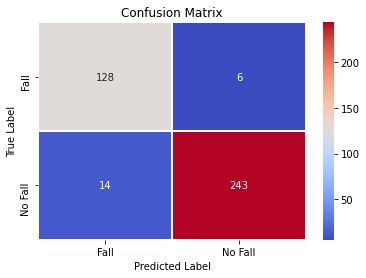


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       134
           1       0.98      0.95      0.96       257

    accuracy                           0.95       391
   macro avg       0.94      0.95      0.94       391
weighted avg       0.95      0.95      0.95       391



In [21]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [22]:
model_m.save('best_model_cnn.h5')